多变量的动态时间规整算法

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/data/week1')
!pwd

Mounted at /content/drive
/content/drive/My Drive/data/week1


In [3]:
!pip install dtw-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 661 kB 7.7 MB/s 


In [4]:
import pandas as pd
import numpy as np
import datetime
import math
import dtw as dtw
from scipy.spatial import distance 

data = pd.read_csv("SH000905.csv")
data['trade_date'] = pd.to_datetime(data['trade_date'], format = '%Y%m%d') 
data.set_index(data['trade_date'],inplace=True)
data.pop('trade_date')
difference = []
for i in range(len(data)):
  difference.append(data['high'][i]-data['low'][i])
data['difference'] = difference
data.head()

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



,code,close,open,high,low,pre_close,change,pct_chg,vol,amount,difference
trade_date,,,,,,,,,,,
2005-01-04,SH000905,986.927,996.682,996.682,984.795,1000.000,-13.073,-1.3073,2323762.03,1329187.122,11.887
2005-01-05,SH000905,1003.633,986.570,1008.855,985.677,986.927,16.706,1.6927,3486101.13,1919861.791,23.178
2005-01-06,SH000905,994.595,1003.490,1003.490,990.792,1003.633,-9.038,-0.9005,2933905.59,1629216.031,12.698
2005-01-07,SH000905,997.606,993.434,1009.000,990.446,994.595,3.011,0.3027,3391626.98,1906530.712,18.554
2005-01-10,SH000905,1006.337,996.928,1006.457,993.123,997.606,8.731,0.8752,2949405.33,1650218.869,13.334


In [5]:
start=datetime.datetime(2005,1,1)
end=datetime.datetime(2017,1,1)
train = data[start: end].reset_index()

start=datetime.datetime(2017,1,1)
end=datetime.datetime(2021,12,31)
test = data[start: end].reset_index()

In [6]:
def dynamicProg(X, Y):
  X = X.reset_index()
  Y = Y.reset_index()
  x = [X['close'], X['vol']]
  y = [Y['close'], Y['vol']]
  ds = dtw.dtw(x, y, step_pattern='asymmetric', open_begin=True, open_end=False)
  return ds.distance

distances_1,distances_2, distances_3 = [], [], []
def findFromHistory(window, history, length):
  minDistance = float('inf')
  minStart = -1
  flag = 0 # indicate short(0) or long(1)
  nxt_day = 0
  for i in range(len(history) - length):
    curDistance = dynamicProg(window, history.iloc[i:i+length])
    # print(curDistance)
    if curDistance < minDistance:
      minDistance = curDistance
      minStart = i
    
      if history.loc[i+length]['change'] > 0:
        flag = 1
      else:
        flag = 0
    # break
  #if abs(history.loc[minStart+length]['pct_chg']) >= 2:
  #distances.append(minDistance)
  return flag, minDistance
correctness_1, correctness_2, correctness_3 = [], [], []
def starter(test, history, winSize, cumulative_return):
  win, lose = 0, 0
  earning = 1
  for i in range(len(test)-winSize):
    window = test[i:i+winSize]
    operation, minDistance = findFromHistory(window, history, winSize)
    '''
    X_std = sc.transform([[minDistance]])
    y_pred = clf.predict(X_std)
    # print(y_pred)
    if y_pred[0] == 0:
      operation = 1 - operation
    '''
    if operation == 1 and test.loc[i+winSize]['pct_chg'] > 0 or operation == 0 and test.loc[i+winSize]['pct_chg'] < 0:
      win += 1
      
      if abs(test.loc[i+winSize]['pct_chg']) >= 1:
        distances_1.append(minDistance)
        correctness_1.append(1)
      if abs(test.loc[i+winSize]['pct_chg']) >= 2:
        distances_2.append(minDistance)
        correctness_2.append(1)
      if abs(test.loc[i+winSize]['pct_chg']) >= 3:
        distances_3.append(minDistance)
        correctness_3.append(1)
      
      if operation == 1:
        earning *= 1 + test.loc[i+winSize]['pct_chg']/100
      else:
        earning *= 1 + abs(test.loc[i+winSize]['pct_chg'])/100
    else:
      lose += 1
      
      if abs(test.loc[i+winSize]['pct_chg']) >= 1:
        distances_1.append(minDistance)
        correctness_1.append(0)
      if abs(test.loc[i+winSize]['pct_chg']) >= 2:
        distances_2.append(minDistance)
        correctness_2.append(0)
      if abs(test.loc[i+winSize]['pct_chg']) >= 3:
        distances_3.append(minDistance)
        correctness_3.append(0)
      
      if operation == 1:
        earning *= 1 + test.loc[i+winSize]['pct_chg']/100
      else:
        earning *= 1 - test.loc[i+winSize]['pct_chg']/100
    # break
    cumulative_return.append(earning)
  print(win, lose, earning-1)
  return (win, lose, earning)


# start, end = 0, 50
# window = data.iloc[-11:].reset_index()
# history = data.iloc[:-11].reset_index()

# dynamicProg(data.iloc[:-11], history.iloc[:11])
# X, Y = [1,4,4,8,3,2,7,9,8,3,1], [2,3,9,6,2,2,5,8,9,4,3]
# dynamicProg(X, Y)


In [7]:
window_list = [10]
rec = []
cumulative_return = []
for i in window_list:
  rec.append(starter(test, train, i, cumulative_return))

597 610 0.05120749672537239


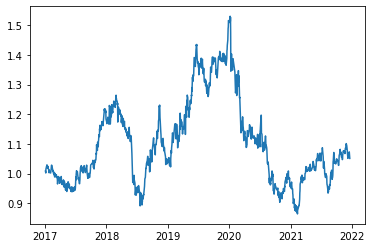

In [8]:
import matplotlib.pyplot as plt
plt.plot(test['trade_date'][:-10], cumulative_return)

In [ ]:
X, Y = np.array(distances_2), np.array(correctness_2)
X = X.reshape(-1, 1)
#Y = Y.reshape(-1, 1)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, Y, test_size=0.2, random_state=42, stratify=Y)
# X_combined_std = np.vstack((X_train_std, X_test_std))

In [ ]:
from numpy.ma.core import array
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
pred_y = clf.predict(X_test)
print(classification_report(y_test, pred_y))


              precision    recall  f1-score   support

           0       0.83      0.31      0.45        16
           1       0.61      0.94      0.74        18

    accuracy                           0.65        34
   macro avg       0.72      0.63      0.60        34
weighted avg       0.71      0.65      0.61        34



In [ ]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(random_state=0)
ppn.fit(X_train, y_train)

# 分类测试集，这将返回一个测试结果的数组
y_pred = ppn.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      1.00      0.59         5
           1       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import RandomForestClassifier     #导入需要的模块
rfc = RandomForestClassifier()                      #实例化
rfc = rfc.fit(X_train,y_train)                      #用训练集数据训练模型
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.56      0.71      0.63         7

    accuracy                           0.50        12
   macro avg       0.44      0.46      0.44        12
weighted avg       0.46      0.50      0.47        12



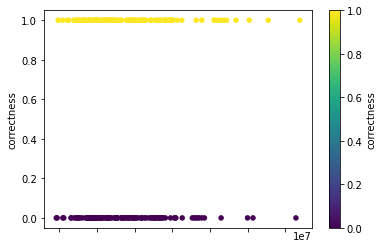

In [ ]:
from pandas.core.frame import DataFrame
d = {'distance': distances, 'correctness': correctness}
df = DataFrame(d)
df.plot.scatter(x='distance' , y='correctness' , c='correctness' , colormap='viridis')

不同参数下的混合策略

In [ ]:
import collections
select_win = []
def starter(test, history, winSize):
  win, lose = 0, 0
  earning = 0
  for winSize in select_win:
    rec = []
    for i in range(len(test)-winSize):
      window = test[i:i+winSize]
      rec.append(findFromHistory(window, history, winSize))
    d = collections.Counter(rec)
    if d[1] > d[0]:
      operation = 1
    else:
      operation = 0
    if operation == 1 and test.loc[i+winSize]['change'] > 0 or operation == 0 and test.loc[i+winSize]['change'] < 0:
      win += 1
      if operation == 1:
        earning *= 1 + test.loc[i+winSize]['change']/test.loc[i+winSize-1]['close']
      else:
        earning *= 1 + abs(test.loc[i+winSize]['change'])/test.loc[i+winSize]['close']
    else:
      lose += 1
      if operation == 1:
        earning *= 1 + test.loc[i+winSize]['change']/test.loc[i+winSize-1]['close']
      else:
        earning *= 1 - abs(test.loc[i+winSize]['change'])/test.loc[i+winSize]['close']
  print(win, lose, earning)
  return